### In this notebook, we show a classification and regression example using the employee dataset. In the classification model, the target variable is "doubling_salary" that shows if an employee would have a double or more salary. This binary target variable is equal to one when salary is doubled and zero otherwise. The target variable in the regression example is "salary_growth" that represents the amount of increase in an employee's salary.

### The explanatory variables include age, edu, jobtime, prevexp, minority and gender. Definition of these explanatory variables is presented below. 

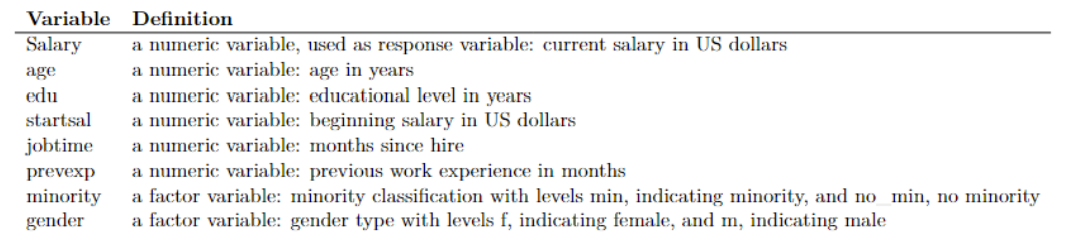

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from safeaipackage import core, check_explainability, check_fairness, check_robustness
from sklearn.metrics import roc_auc_score, root_mean_squared_error
import shap
import warnings

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 10000)

In [2]:
data = pd.read_excel("employee.xlsx")
print("This dataset has {} rows and {} columns".format(data.shape[0], data.shape[1]))
data.head()

This dataset has 473 rows and 8 columns


,salary,age,edu,startsal,jobtime,prevexp,minority,gender
0,57000,36,15,27000,98,144,no_min,m
1,40200,30,16,18750,98,36,no_min,m
2,21450,59,12,12000,98,381,no_min,f
3,21900,41,8,13200,98,190,no_min,f
4,45000,33,15,21000,98,138,no_min,m


In [3]:
data["gender"] = np.where(data["gender"]=="m", 0, 1)
data["minority"] = np.where(data["minority"]=="no_min", 0, 1)
data.head()

,salary,age,edu,startsal,jobtime,prevexp,minority,gender
0,57000,36,15,27000,98,144,0,0
1,40200,30,16,18750,98,36,0,0
2,21450,59,12,12000,98,381,0,1
3,21900,41,8,13200,98,190,0,1
4,45000,33,15,21000,98,138,0,0


In [4]:
data["doubling_salary"] = np.where(data["salary"]/data["startsal"] > 2,1,0)

data["doubling_salary"].value_counts()

doubling_salary
0    253
1    220
Name: count, dtype: int64

In [5]:
data["salary_growth"] = data["salary"]-data["startsal"]

data.drop(["salary", "startsal"], axis=1, inplace=True)
data.head()

,age,edu,jobtime,prevexp,minority,gender,doubling_salary,salary_growth
0,36,15,98,144,0,0,1,30000
1,30,16,98,36,0,0,1,21450
2,59,12,98,381,0,1,0,9450
3,41,8,98,190,0,1,0,8700
4,33,15,98,138,0,0,1,24000


In [6]:
X = data.drop(["doubling_salary", "salary_growth"], axis=1)
y_class = data["doubling_salary"]
y_reg = data["salary_growth"]

xtrain, xtest, ytrain_cl, ytest_cl = train_test_split(X, y_class, test_size=0.3, random_state=1)
_, _, ytrain_rg, ytest_rg = train_test_split(X, y_reg, test_size=0.3, random_state=1)

In [7]:
## classification

rf_clf = RandomForestClassifier(random_state=123)
rf_clf.fit(xtrain, ytrain_cl)
rf_clf_predicted_proba = rf_clf.predict_proba(xtest)[:,1]

log_clf = LogisticRegression(random_state=123)
log_clf.fit(xtrain, ytrain_cl)
log_clf_predicted_proba = log_clf.predict_proba(xtest)[:,1]

In [8]:
## regression

rf_reg = RandomForestRegressor(random_state=123)
rf_reg.fit(xtrain, ytrain_rg)
rf_reg_predicted = rf_reg.predict(xtest)

lin_reg = LinearRegression()
lin_reg.fit(xtrain, ytrain_rg)
lin_reg_predicted = lin_reg.predict(xtest)

# Evaluate models and interpret the results

### Accuracy

In [9]:
## ACCURACY _ classification

auc_rf = roc_auc_score(ytest_cl, rf_clf_predicted_proba)
auc_log = roc_auc_score(ytest_cl, log_clf_predicted_proba)
rga_rf_clf = core.rga(ytest_cl, rf_clf_predicted_proba)
rga_log_clf = core.rga(ytest_cl, log_clf_predicted_proba)

print(f"AUC value for the Random Forest classifier is equal to {auc_rf}")
print(f"AUC value for the Logistic Regression classifier is equal to {auc_log}")
print(f"RGA value for the Random Forest classifier is equal to {rga_rf_clf}")
print(f"RGA value for the Logistic Regression classifier is equal to {rga_log_clf}")

AUC value for the Random Forest classifier is equal to 0.7682291666666667
AUC value for the Logistic Regression classifier is equal to 0.7523036858974359
RGA value for the Random Forest classifier is equal to 0.7682291666666666
RGA value for the Logistic Regression classifier is equal to 0.7523036858974359


In [14]:
## ACCURACY _ regression

rmse_rf_reg = root_mean_squared_error(ytest_rg, rf_reg_predicted)
rmse_lin_reg = root_mean_squared_error(ytest_rg, lin_reg_predicted)
rga_rf_reg = core.rga(ytest_rg, rf_reg_predicted)
rga_lin_reg = core.rga(ytest_rg, lin_reg_predicted)

print(f"RMSE for the Random Forest regressor is equal to {rmse_rf_reg}")
print(f"RMSE for the Linear regressor is equal to {rmse_lin_reg}")
print(f"RGA value for the Random Forest regressor is equal to {rga_rf_reg}")
print(f"RGA value for the Linear regressor is equal to {rga_lin_reg}")

RMSE for the Random Forest regressor is equal to 8317.377012022518
RMSE for the Linear regressor is equal to 9017.4676863756
RGA value for the Random Forest regressor is equal to 0.8938299653322788
RGA value for the Linear regressor is equal to 0.892511971607103


### Explainability

#### Random Forest feature importance 

In [15]:
rf_clf_importances = rf_clf.feature_importances_
rf_clf_importances

array([0.25723493, 0.09129307, 0.28166406, 0.31191454, 0.02667007,
       0.03122333])

In [16]:
feature_names = xtrain.columns  
rf_clf_feat_imp = pd.Series(rf_clf_importances, index=feature_names).sort_values(ascending=False)
rf_clf_feat_imp

prevexp     0.311915
jobtime     0.281664
age         0.257235
edu         0.091293
gender      0.031223
minority    0.026670
dtype: float64

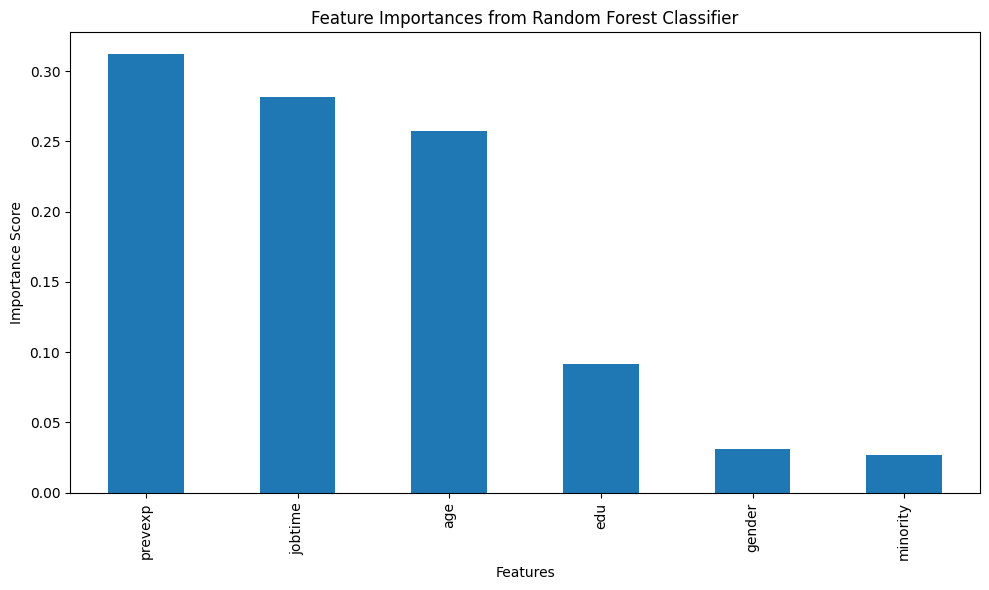

In [17]:
plt.figure(figsize=(10,6))
rf_clf_feat_imp.plot(kind='bar')
plt.title('Feature Importances from Random Forest Classifier')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

In [18]:
rf_reg_importances = rf_reg.feature_importances_
rf_reg_importances

array([0.11973168, 0.4871367 , 0.1673206 , 0.15698856, 0.0187251 ,
       0.05009736])

In [19]:
rf_reg_feat_imp = pd.Series(rf_reg_importances, index=feature_names).sort_values(ascending=False)
rf_reg_feat_imp

edu         0.487137
jobtime     0.167321
prevexp     0.156989
age         0.119732
gender      0.050097
minority    0.018725
dtype: float64

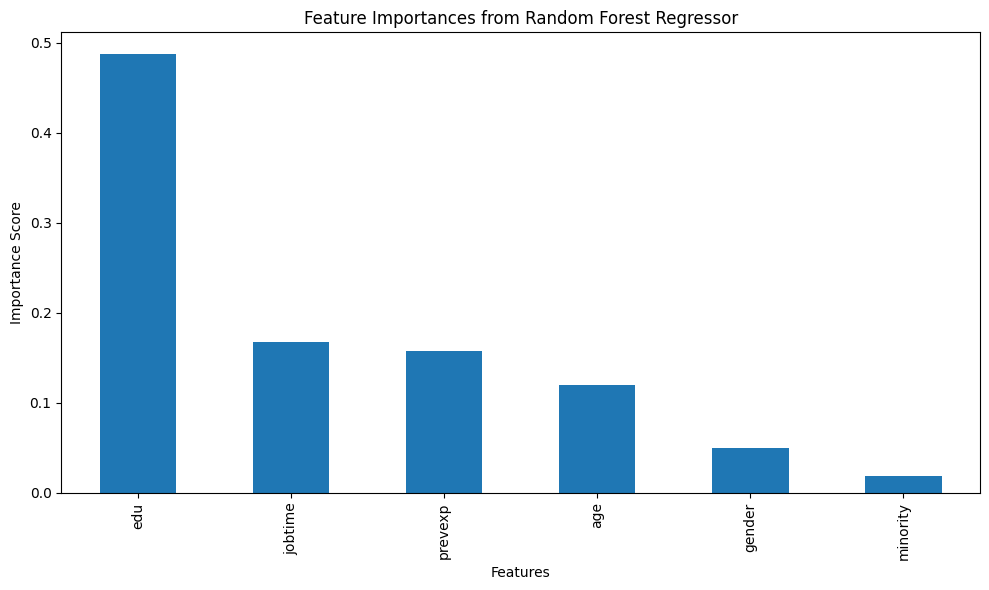

In [20]:
plt.figure(figsize=(10,6))
rf_reg_feat_imp.plot(kind='bar')
plt.title('Feature Importances from Random Forest Regressor')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

### SHAP

In [21]:
rf_clf_explainer = shap.TreeExplainer(rf_clf)
rf_clf_shap_vals = rf_clf_explainer.shap_values(xtrain)

rf_local_shap_values = []
for val in rf_clf_shap_vals:
    rf_local_shap_values.append(val[:,1])

rf_shapley_values_df = pd.DataFrame(rf_local_shap_values, columns= xtest.columns)
rf_shapley_values_df

,age,edu,jobtime,prevexp,minority,gender
0,0.179410,0.015627,0.092558,0.188615,-0.004435,0.029041
1,-0.216050,-0.022102,-0.036185,-0.141768,-0.016737,-0.036342
2,-0.102426,-0.001474,-0.083655,-0.157949,0.005385,-0.029066
3,0.198792,0.010791,0.159852,0.096917,0.029207,0.015257
4,0.086145,-0.128824,-0.126728,-0.000650,-0.016931,-0.022196
5,0.068504,0.038384,0.034874,0.049034,0.025940,0.034079
6,-0.149969,0.011151,-0.070270,-0.121530,-0.023986,-0.034580
7,0.100802,0.158275,0.029380,0.171577,0.008779,0.022002
8,0.182111,0.037312,0.064614,0.157965,-0.000101,0.008082
9,-0.018555,0.014150,0.175107,-0.007796,0.085730,-0.017821


In [22]:
rf_clf_global_shap_values = np.abs(rf_shapley_values_df).mean()

rf_clf_global_shap_values

age         0.115705
edu         0.041568
jobtime     0.118211
prevexp     0.102938
minority    0.016693
gender      0.020985
dtype: float64

In [23]:
rf_clf_global_shap_values = pd.DataFrame(rf_clf_global_shap_values, columns= ["SHAP"]).sort_values(by= "SHAP")
rf_clf_global_shap_values

,SHAP
minority,0.016693
gender,0.020985
edu,0.041568
prevexp,0.102938
age,0.115705
jobtime,0.118211


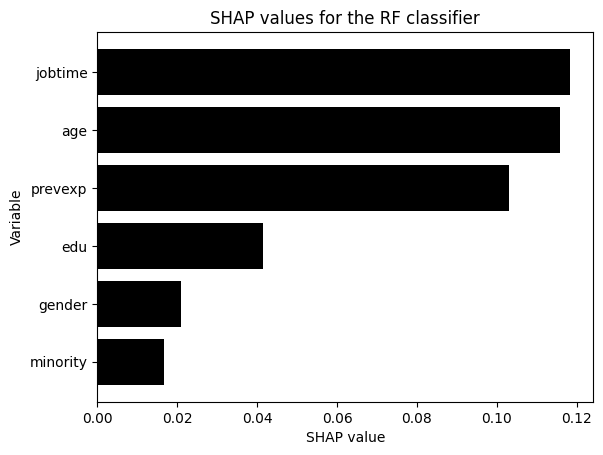

In [25]:
plt.barh(rf_clf_global_shap_values.index,rf_clf_global_shap_values["SHAP"], color= "black")
plt.xlabel("SHAP value")
plt.ylabel("Variable")
plt.title("SHAP values for the RF classifier")
plt.savefig("shap.png")

In [26]:
## EXPLAINABILITY ##
## Compute_rge_values is a function to measure contribution of the given variables
## Here RGE of the model for "age" is found. In particular, the effect of this variable on the model decisions is ignored 
## (based on the defined function) and then performance of the model including and excluding effect of "age" are compared.
## Higher RGE shows a higher contribution for the variable

# classification _ random forest
check_explainability.compute_rge_values(xtrain, xtest, rf_clf_predicted_proba, rf_clf, ["age"])

,RGE
age,0.096878


In [27]:
# regression _ random forest
check_explainability.compute_rge_values(xtrain, xtest, rf_reg_predicted, rf_reg, ["age"])

,RGE
age,0.03592


In [28]:
## Here it is shown that it is possible to give a list of variables to this function
# classification
check_explainability.compute_rge_values(xtrain, xtest, rf_clf_predicted_proba, rf_clf, ["age", "edu"])

,RGE
age,0.096878
edu,0.026247


In [61]:
# regression
check_explainability.compute_rge_values(xtrain, xtest, rf_reg_predicted, rf_reg, ["age", "edu"])

,RGE
edu,0.174166
age,0.035920


In [29]:
rge_df = check_explainability.compute_rge_values(xtrain, xtest, rf_clf_predicted_proba, rf_clf, list(xtest.columns))
rge_df.sort_values(by="RGE", ascending= True, inplace= True)
rge_df

,RGE
minority,0.004168
gender,0.014404
edu,0.026247
prevexp,0.078451
age,0.096878
jobtime,0.166899


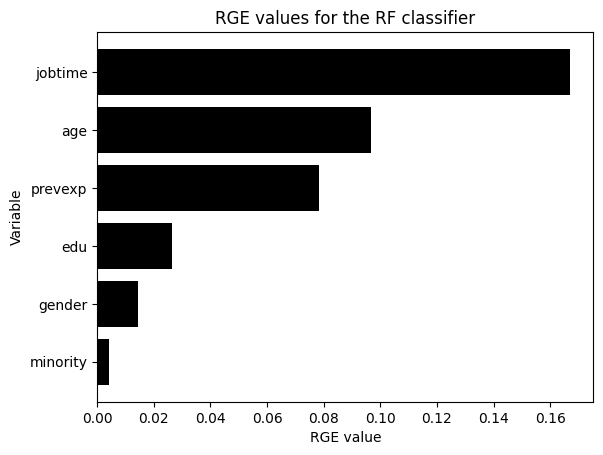

In [30]:
plt.barh(rge_df.index, rge_df["RGE"], color= "black")
plt.xlabel("RGE value")
plt.ylabel("Variable")
plt.title("RGE values for the RF classifier")
plt.savefig("rge.png")

In [31]:
## It is also possible to measure contribution of a group of the variables
# classification
check_explainability.compute_rge_values(xtrain, xtest, rf_clf_predicted_proba, rf_clf, ["edu", "prevexp"], group= True)

,RGE
"['edu', 'prevexp']",0.103867


In [32]:
# regression
check_explainability.compute_rge_values(xtrain, xtest, rf_reg_predicted, rf_reg, ["edu", "prevexp"], group= True)

,RGE
"['edu', 'prevexp']",0.212545


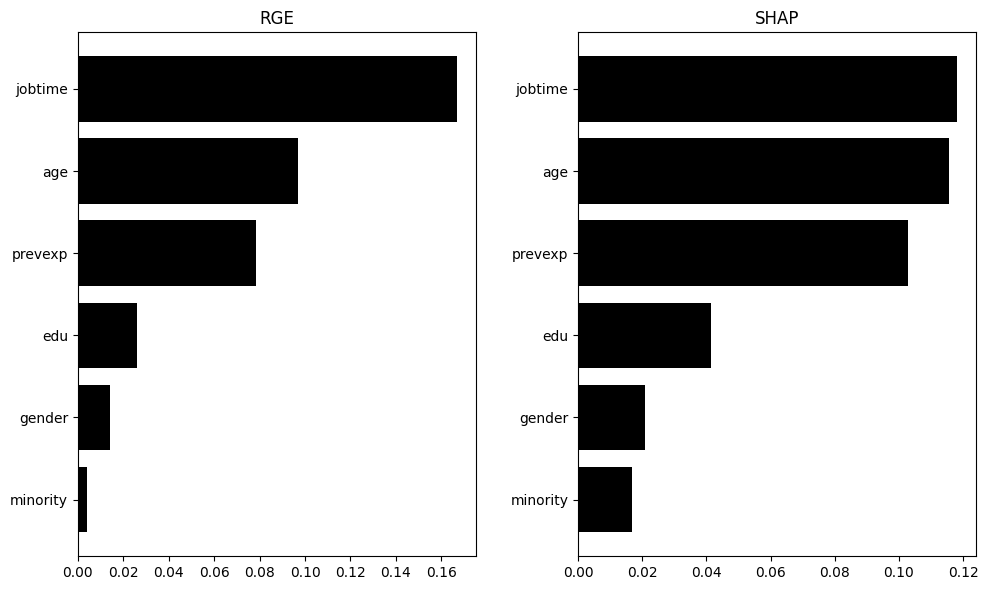

In [33]:
fig, ax = plt.subplots(1,2, figsize= (10,6))

ax[0].barh(rge_df.index, rge_df["RGE"], color="black")
ax[0].set_title("RGE")

ax[1].barh(rf_clf_global_shap_values.index, rf_clf_global_shap_values["SHAP"], color="black")
ax[1].set_title("SHAP")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig("rge_shap.png")
plt.show()

### Fairness

In [34]:
## FAIRNESS
## Using compute_rga_parity function, the imparity of the model based on RGA is calculated.

# classification
check_fairness.compute_rga_parity(xtrain, xtest, ytest_cl, rf_clf_predicted_proba, rf_clf, "gender")

'The RGA-based imparity between the protected gorups is 0.05476190476190468.'

In [35]:
# regression
check_fairness.compute_rga_parity(xtrain, xtest, ytest_rg, rf_reg_predicted, rf_reg, "gender")

'The RGA-based imparity between the protected gorups is 0.04793503449091785.'

### Robustness

In [36]:
## ROBUSTNESS
## Compute_rgr_values is a function designed to measure robustness of the catboost classifier towards perturbations of 
## the variables

# classification
check_robustness.compute_rgr_values(xtest, rf_clf_predicted_proba, rf_clf, list(xtest.columns))

,RGR
gender,0.998071
minority,0.997354
edu,0.994639
age,0.977716
prevexp,0.972397
jobtime,0.945532


In [37]:
# regression
check_robustness.compute_rgr_values(xtest, rf_reg_predicted, rf_reg, list(xtest.columns))

,RGR
minority,0.999678
prevexp,0.998228
gender,0.995540
age,0.993973
jobtime,0.983821
edu,0.882089


In [38]:
## It is possible to find the robustness of the model towards the modification of variables based on different perturbation percentages
check_robustness.compute_rgr_values(xtest, rf_reg_predicted, rf_reg, list(xtest.columns), perturbation_percentage= 0.3)

,RGR
minority,0.998672
prevexp,0.975987
gender,0.970913
jobtime,0.965406
age,0.908045
edu,0.502502
